This is a Poisson equation with Dirichlet and Neumann boundary conditions solved with a PINN model using the DeepXDE library.

<br>

\begin{equation}
Δu = 2 \hspace{1cm} x∈[−1,1]
\end{equation}

<br>

\begin{equation}
u'(-1) = 4 \hspace{1cm} u(-1) = 0
\end{equation}

Test losses after 6000 epochs are approximately:

*In accordance to y output:* **1.35e-05**

*In accordance to boundary conditions:* **1.14e-06**, **1.64e-07**

*In accordance to the known solution:* **5.94e-04**

In [ ]:
# Importing libraries
  
!pip install deepxde
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-1, 1)

In [ ]:
# Define the differencial equation

def ode(x,y):
  du_xx = dde.grad.hessian(y,x)
  return du_xx - 2

In [ ]:
# Define boundary conditions

def ic_dy (x,_):
  return np.isclose(x[0], 1)

def ic_y (x,_):
  return np.isclose(x[0], -1)

ic1 = dde.NeumannBC(geom, lambda x: 4, ic_dy)
ic2 = dde.DirichletBC(geom, lambda x: 0, ic_y)

In [ ]:
# Define known solution

def sol(x):
  return (x+1)**2

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [ic1,ic2], num_domain=1000, num_boundary=10, solution=sol, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [60] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN (layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics = ["l2 relative error"])

losshistory, train_state = model.train(epochs = 6000)

Compiling model...
Building feed-forward neural network...
'build' took 0.078859 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.607847 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.01e+00, 1.31e+01, 1.86e-01]    [4.01e+00, 1.31e+01, 1.86e-01]    [9.12e-01]    
1000      [2.29e-02, 7.59e-02, 2.90e-02]    [2.22e-02, 7.59e-02, 2.90e-02]    [6.51e-02]    
2000      [3.80e-03, 1.32e-02, 3.90e-03]    [3.85e-03, 1.32e-02, 3.90e-03]    [2.38e-02]    
3000      [7.14e-04, 1.35e-03, 1.42e-03]    [6.95e-04, 1.35e-03, 1.42e-03]    [1.53e-02]    
4000      [2.22e-04, 5.13e-04, 9.74e-05]    [2.15e-04, 5.13e-04, 9.74e-05]    [4.77e-03]    
5000      [5.61e-05, 7.92e-05, 7.31e-06]    [5.51e-05, 7.92e-05, 7.31e-06]    [1.62e-03]    
6000      [1.55e-05, 1.14e-06, 1.64e-07]    [1.35e-05, 1.14e-06, 1.64e-07]    [5.94e-04]    

Best model at step 6000:
  train loss: 1.68e-05
  test loss: 1.48e-05
  test metric: [5.94e-04]

'train' took 59.418522 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


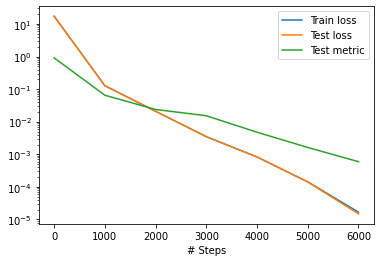

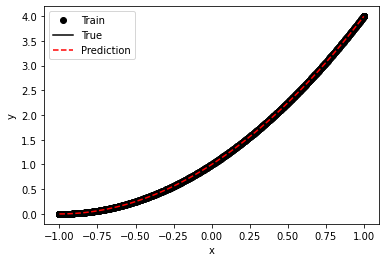

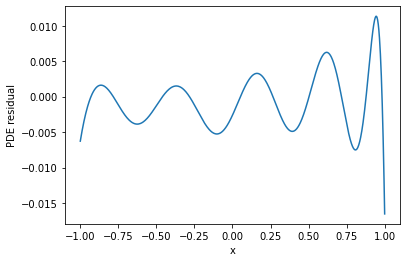

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()